In [14]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

## Verify Metadata


In [15]:
meta = pd.read_csv("/data2/datasets/clobotics/ccth/indices/ccth_sku_metadata_0120.csv")
head_sku_list = pd.read_csv("/home/rlan/Downloads/sku_ccth_head_sku.txt").SystemId.tolist()

#### Some Product has no SubBrandId

- There're total 10 such rows. 
- Every row's ProductId is the same as CategoryId.
- There're total 13 distinct categories, these 10 categories contains 932/935 products.
- The other 3 categories are 1063798, 1063799, 1063800

In [5]:
meta[pd.isnull(meta.SubBrandId)]

,ProductId,SKUType,Package,UnitCount,Volume,VolumeType,Industry,Juice,CategoryId,Brand,SubBrand,SubBrandId,Series,Flavor,Market,SKUName
260,1037848,tail,NaN,NaN,NaN,NaN,Drink,Beer,1037848,NaN,NaN,NaN,NaN,NaN,Thailand,Beer-Other
261,1037849,tail,NaN,NaN,NaN,NaN,Drink,Wine,1037849,NaN,NaN,NaN,NaN,NaN,Thailand,Wine-Other
262,1037850,tail,NaN,NaN,NaN,NaN,Drink,Sparkling,1037850,NaN,NaN,NaN,NaN,NaN,Thailand,Sparkling-Other
263,1037851,tail,NaN,NaN,NaN,NaN,Drink,Water,1037851,NaN,NaN,NaN,NaN,NaN,Thailand,Water-Other
264,1037852,tail,NaN,NaN,NaN,NaN,Drink,Juice,1037852,NaN,NaN,NaN,NaN,NaN,Thailand,Juice-Other
265,1037853,tail,NaN,NaN,NaN,NaN,Drink,Sports Drink,1037853,NaN,NaN,NaN,NaN,NaN,Thailand,Sports Drink-Other
406,1051447,tail,NaN,NaN,NaN,NaN,Drink,Dairy,1051447,NaN,NaN,NaN,NaN,NaN,Thailand,Dairy-Other
407,1051448,tail,NaN,NaN,NaN,NaN,Drink,Coffee,1051448,NaN,NaN,NaN,NaN,NaN,Thailand,Coffee-Other
409,1051868,tail,NaN,NaN,NaN,NaN,Drink,Tea,1051868,NaN,NaN,NaN,NaN,NaN,Thailand,Tea-Other
410,1051869,tail,NaN,NaN,NaN,NaN,Drink,Energy,1051869,NaN,NaN,NaN,NaN,NaN,Thailand,Energy-Other


In [6]:
len(meta[meta.CategoryId.isin(meta[pd.isnull(meta.SubBrandId)].CategoryId.values)])

932

In [25]:
len(meta)

935

In [26]:
meta.CategoryId.unique().tolist()

[1037848,
 1037849,
 1037850,
 1037851,
 1037852,
 1037853,
 1051447,
 1051868,
 1051869,
 1051448,
 1063798,
 1063799,
 1063800]

In [27]:
meta[meta.CategoryId.isin([1063798, 1063799, 1063800])]

,ProductId,SKUType,Package,UnitCount,Volume,VolumeType,Industry,Juice,CategoryId,Brand,SubBrand,SubBrandId,Series,Flavor,Market,SKUName
821,1080731,NaN,NaN,NaN,NaN,NaN,Drink,Sports Drink,1063798,NaN,Moove Protein Water,1037853.0,NaN,NaN,Thailand,Moove Protein Water Sports Drink-Other
822,1080732,NaN,NaN,NaN,NaN,NaN,Drink,Juice,1063799,NaN,Andalus,1037852.0,NaN,NaN,Thailand,Andalus Juice-Other
823,1080733,NaN,NaN,NaN,NaN,NaN,Drink,Sports Drink1037853,1063800,NaN,Gatorade,1037853.0,NaN,NaN,Thailand,Gatorade Sports Drink-Other


#### Check whether there's overlap between subbrand

In [11]:
product_ids_in_each_subbrand = meta.groupby("SubBrandId")["ProductId"].apply(lambda x: ','.join(x.astype(str)))

In [14]:
len(",".join(product_ids_in_each_subbrand.values).split(","))

925

In [17]:
meta[~pd.isnull(meta.SubBrandId)]["ProductId"].unique().shape

(925,)

#### check whether there's overlap between categories

In [19]:
product_ids_in_each_category = meta.groupby("CategoryId")["ProductId"].apply(lambda x: ','.join(x.astype(str)))

In [20]:
len(",".join(product_ids_in_each_category.values).split(","))

935

In [21]:
meta[~pd.isnull(meta.CategoryId)]["ProductId"].unique().shape

(935,)

#### check how many subbrand and their distribution

In [13]:
meta.SubBrandId.value_counts()

1037838.0    59
1037818.0    53
1037823.0    24
1037836.0    23
1037810.0    21
             ..
1079405.0     1
1065243.0     1
1065279.0     1
1079407.0     1
1079296.0     1
Name: SubBrandId, Length: 429, dtype: int64

#### check how many subbrand only contains 1 sku

In [10]:
prod_list = meta[meta.SubBrandId == meta.ProductId].ProductId.values
meta[meta.ProductId.isin(prod_list)].shape

(314, 16)

## Verify Validation set and metadata

In [2]:
val = pd.read_csv("/data2/datasets/clobotics/ccth/labels/val/20200117/test_data_ccth_20200117.csv")

In [45]:
sku_ids_from_label_csv = val.ProductId.unique()
len(sku_ids_from_label_csv)

708

#### Check whether all the skus shown up are defined in metadata

- 1, 1265, 1000050, 1053247, 1070847, 1072770, 1079969, 1080433, 1080718, 1080801 not defined in meta csv


In [46]:
set(sku_ids_from_label_csv) - set(meta.ProductId.tolist())

{1,
 1265,
 1000050,
 1053247,
 1070847,
 1072770,
 1079969,
 1080433,
 1080718,
 1080801}

#### check some columns' distinct values

In [42]:
val.ImageQuality.unique()

array(['[]', '["Unqualified"]', '["无目标产品"]'], dtype=object)

In [43]:
val.Rotation.unique()

array([0])

In [44]:
val.SceneType.unique()

array(['[]'], dtype=object)

## Check Distribution of SKUs

#### Check whether there're SKUs lack of eval_cnt in the VAL set

In [3]:
val = pd.read_csv("/data2/datasets/clobotics/ccth/labels/val/20200117/test_data_ccth_20200117.csv")
head_sku_list = pd.read_csv("/data2/datasets/clobotics/ccth/indices/sku_ccth_head_sku.txt").SystemId.values

stats = val[val.ProductId.isin(head_sku_list)]["ProductId"].value_counts()

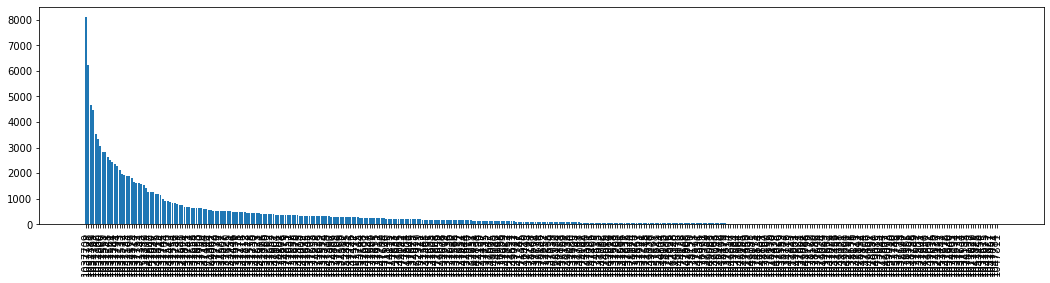

In [8]:
plt.figure(figsize=(18, 4))
_ = plt.bar(stats.index.astype(str), stats.values)
_ = plt.xticks(rotation=90)

In [19]:
print(f"Total number of SKUs in head sku list: {len(head_sku_list)}")
print(f"Total number of SKUs in VAL set: {len(stats)}")
print(f"Number of SKUs in valset has more than 50 samples: {(stats >= 50).sum()} ({(stats >= 50).sum() / len(stats) * 100:.1f}%)")
print(f"Number of SKUs in valset has more than 20 samples: {(stats >= 20).sum()} ({(stats >= 20).sum() / len(stats) * 100:.1f}%)")
print(f"Number of SKUs in valset has more than 10 samples: {(stats >= 10).sum()} ({(stats >= 10).sum() / len(stats) * 100:.1f}%)")
print(f"Number of SKUs in valset has more than 5 samples: {(stats >= 5).sum()} ({(stats >= 5).sum() / len(stats) * 100:.1f}%)")

Total number of SKUs in head sku list: 455
Total number of SKUs in VAL set: 380
Number of SKUs in valset has more than 50 samples: 233 (61.3%)
Number of SKUs in valset has more than 20 samples: 295 (77.6%)
Number of SKUs in valset has more than 10 samples: 325 (85.5%)
Number of SKUs in valset has more than 5 samples: 344 (90.5%)


#### Check whether there're SKUs lack of eval_cnt in the TRAIN set

In [4]:
train = pd.concat([pd.read_csv(p) for p in Path("/data2/datasets/clobotics/ccth/labels/train/20200129").glob("*.csv")])
head_sku_list = pd.read_csv("/data2/datasets/clobotics/ccth/indices/sku_ccth_head_sku.txt").SystemId.values
stats = train[train.ProductId.isin(head_sku_list)]["ProductId"].value_counts()

In [22]:
print(f"Total number of SKUs in head sku list: {len(head_sku_list)}")
print(f"Total number of SKUs in TRAIN set: {len(stats)}")
print(f"Number of SKUs in valset has more than 200 samples: {(stats >= 200).sum()} ({(stats >= 200).sum() / len(stats) * 100:.1f}%)")
print(f"Number of SKUs in valset has more than 100 samples: {(stats >= 100).sum()} ({(stats >= 100).sum() / len(stats) * 100:.1f}%)")
print(f"Number of SKUs in valset has more than 50 samples: {(stats >= 50).sum()} ({(stats >= 50).sum() / len(stats) * 100:.1f}%)")
print(f"Number of SKUs in valset has more than 20 samples: {(stats >= 20).sum()} ({(stats >= 20).sum() / len(stats) * 100:.1f}%)")
print(f"Number of SKUs in valset has more than 10 samples: {(stats >= 10).sum()} ({(stats >= 10).sum() / len(stats) * 100:.1f}%)")
print(f"Number of SKUs in valset has more than 5 samples: {(stats >= 5).sum()} ({(stats >= 5).sum() / len(stats) * 100:.1f}%)")

Total number of SKUs in head sku list: 455
Total number of SKUs in TRAIN set: 401
Number of SKUs in valset has more than 200 samples: 275 (68.6%)
Number of SKUs in valset has more than 100 samples: 304 (75.8%)
Number of SKUs in valset has more than 50 samples: 333 (83.0%)
Number of SKUs in valset has more than 20 samples: 363 (90.5%)
Number of SKUs in valset has more than 10 samples: 374 (93.3%)
Number of SKUs in valset has more than 5 samples: 381 (95.0%)


#### Check whether TRAIN and VAL set distribution conform

In [5]:
val_stats = val[val.ProductId.isin(head_sku_list)]["ProductId"].value_counts()
train_stats = train[train.ProductId.isin(head_sku_list)]["ProductId"].value_counts()

In [14]:
# val_distribution = np.zeros(len(head_sku_list))
# train_distribution = np.zeros(len(head_sku_list))
val_distribution = np.array([val_stats.get(sku) or 0.0 for sku in head_sku_list])
train_distribution = np.array([train_stats.get(sku) or 0.0 for sku in head_sku_list])
val_distribution = val_distribution / val_distribution.sum()
train_distribution = train_distribution / train_distribution.sum()

In [21]:
def kl_divergence(a, b):
    return np.sum(np.where((a != 0) & (b != 0), a * np.log(a / b), 0))

In [22]:
kl_divergence(val_distribution, train_distribution)

/home/rlan/anaconda3/envs/cuml_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/rlan/anaconda3/envs/cuml_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/rlan/anaconda3/envs/cuml_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/rlan/anaconda3/envs/cuml_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


0.2733246131415151

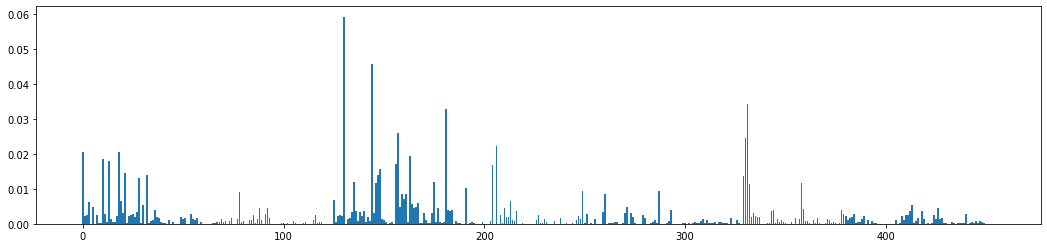

In [16]:
plt.figure(figsize=(18, 4))
_ = plt.bar(np.arange(len(val_distribution)), val_distribution)

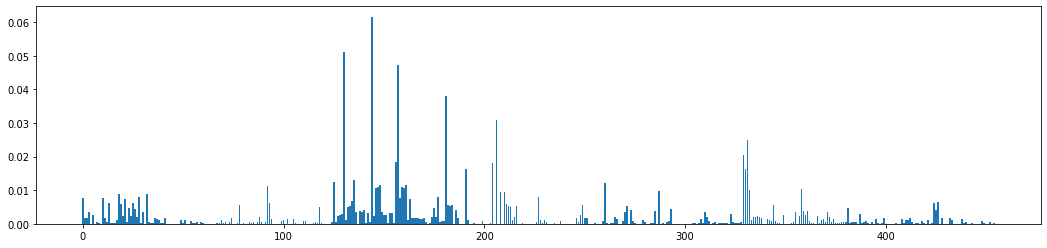

In [17]:
plt.figure(figsize=(18, 4))
_ = plt.bar(np.arange(len(train_distribution)), train_distribution)

### find sku in each category that occurred the most

In [6]:
val_meta = pd.merge(val, meta, on="ProductId", how="left")

In [19]:
for category_id in [1037848,1037849,1037850,1037851,1037852,1037853,1051447,1051868,1051869,1051448]:
    print(f"\n------ {category_id} -------")
    top = val_meta[val_meta.CategoryId == category_id].groupby("ProductId")["ProductId"].count().sort_values(ascending=False)[:10]
    print(top)


------ 1037848 -------
ProductId
1037569    2818
1037551    2814
1037561    2529
1037564    2452
1052396     415
1037562     402
1037553     331
1037552     315
1079328     276
1037848     256
Name: ProductId, dtype: int64

------ 1037849 -------
ProductId
1037554    846
1037556    652
1037558    350
1079344    289
1037568    288
1052395    283
1037805    162
1037809    123
1037849    120
1082150    105
Name: ProductId, dtype: int64

------ 1037850 -------
ProductId
1037709    8092
1037728    6226
1037769    4472
1037742    3543
1037748    2632
1037741    2343
1037733    2139
1037572    1972
1037732    1913
1037583    1899
Name: ProductId, dtype: int64

------ 1037851 -------
ProductId
1037800    3042
1037851    2985
1051439    1557
1079451    1423
1037654     630
1077653     628
1079368     547
1079248     394
1077651     363
1037802     341
Name: ProductId, dtype: int64

------ 1037852 -------
ProductId
1037852    4451
1037794    2288
1037779    1403
1037828    1242
1079294    1104


In [20]:
chosen_sku_ids = [1079300,1037852,1079267,1062858,1079259,1052380,1037800,1037794,1079298,1072766,1052382,1072769,1079460,1082140,1037833,1051440,1037611,1082144,1082177,1037807,1079343]
[p for p in os.listdir("/tmp/clust-exp") if int(p.split("#")[0]) in chosen_sku_ids]

["1079267#Brands'#Energy-Other",
 '1037794#RB#250ML#Minute#Maid#Splash',
 '1079259#Betagen#Dairy-Other',
 '1037807#Chang#Beer-Other',
 '1037800#PET#550ML#Namthip#Drinking#Water',
 '1082144#J-Mix#Juice-Other#',
 '1079460#Unif#Juice-Other',
 '1079298#Dutchie#Dairy-Other',
 '1082177#The#Shogun#Juice-Other',
 '1082140#Jele#Light#Juice-Other',
 '1079343#Jele#Double#Jelly#Juice-Other',
 '1037611#SLE#250ML#EST#Play#Grape#Berry',
 '1037852#Juice-Other',
 '1052382#RB#100ML#Lipovitan-D',
 '1037833#Malee#Healti#Plus#Juice-Other',
 '1072766#Vitamilk#Dairy-other',
 '1062858#CAN#180ML#Birdy#Coffee#Robusta',
 '1072769#Magic#Dairy-other',
 '1052380#RB#150ML#Carabao',
 '1051440#Singha#Soda#Water#Sparkling-Other',
 '1079300#Dutch#Mill#DKY#Dairy-Other']